<a href="https://colab.research.google.com/github/JoeOlang/NLP/blob/gh-pages/Text%20Classification/Swahili/ZindiNews/v1.7_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#!pip install ktrain



---



In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import ktrain
from ktrain import text

In [ ]:
import re
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords

In [ ]:
def processText(text):
    text = text.lower()
    text = word_tokenize(text)
    return ' '.join(text)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

Model_Name = 'bert-base-multilingual-uncased'

t = text.Transformer(Model_Name, maxlen=128, class_names=['kitaifa', 'michezo', 'biashara', 'kimataifa', 'burudani'])

In [ ]:
# Introduce some common Swahili stop words

stop_words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/swahili_stopwords.csv')
stop_words = stop_words_df['StopWords'].tolist()

In [ ]:
# data import & basic prep

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Train.csv')
df['category'] = df['category'].str.lower()

test_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Test.csv'

val_df = pd.read_csv(test_path)
val_df['content'] = val_df['content'].str.lower()

df.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,kitaifa


In [ ]:
# Percentage of news with text
total = df['content'].notnull().sum()
round((total/len(df)*100),1)

100.0

In [ ]:
# cleaning

df['content'] = df['content'].apply(processText)
val_df['content'] = val_df['content'].apply(processText)

In [ ]:
valid_pred = np.zeros((len(val_df), 5))

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight


In [ ]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(df['category']), df['category'])
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1, restore_best_weights = True)

seed = 42
n_folds = 10

skf = StratifiedKFold(n_splits = n_folds, random_state = seed, shuffle = False)
n = 0

for train_index, test_index in skf.split(df['content'], df['category']):
    x_train, x_test = list(df.loc[train_index, 'content']), list(df.loc[test_index, 'category'])
    y_train, y_test = np.asarray(df.loc[train_index, 'category']), np.asarray(df.loc[test_index, 'category'])

    train = t.preprocess_train(x_train, y_train)
    val = t.preprocess_test(x_test, y_test)

    model = t.get_classifier()

    learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=6)

    history = learner.fit(1e-5, 10, cycle_len = 1, cycle_mult = 2, class_weight = class_weight_dict, callbacks = [es], checkpoint_folder = '/tmp')

    learner.validate(class_names = t.get_classes())

    if max(history.history['val_accuracy']) < 0.8:
        continue

    predictor = ktrain.get_predictor(learner.model, preproc = t)
    data = val_df['content']
    data = np.asarray(data)

    print(predictor.get_classes())
    pred = predictor.predict(data, return_proba = True)
    n = n + 1

    valid_pred += pred

valid_pred /= n

preprocessing train...
language: sw
train sequence lengths:
	mean : 345
	95percentile : 770
	99percentile : 1186


Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1



Epoch 1/1023
773/773 [==============================] - 171s 204ms/step - loss: 1.2160 - accuracy: 0.5622 - val_loss: 2.0871 - val_accuracy: 0.0039
Epoch 2/1023
773/773 [==============================] - 157s 204ms/step - loss: 0.9338 - accuracy: 0.6470 - val_loss: 2.7146 - val_accuracy: 0.0039
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5978 - accuracy: 0.7454 - val_loss: 2.8186 - val_accuracy: 0.0039
Epoch 4/1023
773/773 [==============================] - 157s 204ms/step - loss: 0.6500 - accuracy: 0.7290 - val_loss: 1.8462 - val_accuracy: 0.0039
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      1.00      0.01         2
   kimataifa       0.00      0.00      0.00         6
     kitaifa       0.00      0.00      0.00       200
     michezo       0.00      0.00      0.00       17

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 170s 206ms/step - loss: 1.2631 - accuracy: 0.5708 - val_loss: 1.3335 - val_accuracy: 0.3456
Epoch 2/1023
773/773 [==============================] - 157s 203ms/step - loss: 1.0101 - accuracy: 0.6327 - val_loss: 1.9008 - val_accuracy: 0.0136
Epoch 3/1023
773/773 [==============================] - 157s 203ms/step - loss: 0.6444 - accuracy: 0.7429 - val_loss: 2.1866 - val_accuracy: 0.0136
Epoch 4/1023
773/773 [==============================] - 157s 203ms/step - loss: 0.6526 - accuracy: 0.7567 - val_loss: 2.9274 - val_accuracy: 0.2777
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         1
   kimataifa       0.02      1.00      0.03         6
     kitaifa       0.00      0.00      0.00       200
     michezo       1.00      1.00      1.00       172

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 171s 207ms/step - loss: 1.2356 - accuracy: 0.6275 - val_loss: 1.4527 - val_accuracy: 0.5981
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.9356 - accuracy: 0.6933 - val_loss: 2.2678 - val_accuracy: 0.2660
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.4951 - accuracy: 0.8113 - val_loss: 2.2508 - val_accuracy: 0.2660
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5473 - accuracy: 0.7927 - val_loss: 3.4975 - val_accuracy: 0.0019
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.95      1.00      0.97       136
    burudani       0.00      0.00      0.00         1
   kimataifa       0.00      0.00      0.00         6
     kitaifa       0.00      0.00      0.00       200
     michezo       0.46      1.00      0.63       172

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 209ms/step - loss: 1.2420 - accuracy: 0.6003 - val_loss: 1.4949 - val_accuracy: 0.3340
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7116 - accuracy: 0.6857 - val_loss: 3.6343 - val_accuracy: 0.0019
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.4104 - accuracy: 0.8227 - val_loss: 2.9038 - val_accuracy: 0.0019
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.3914 - accuracy: 0.8208 - val_loss: 2.4686 - val_accuracy: 0.3340
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         1
   kimataifa       0.00      0.00      0.00         6
     kitaifa       0.00      0.00      0.00       200
     michezo       0.56      1.00      0.72       172

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 171s 207ms/step - loss: 1.2895 - accuracy: 0.5431 - val_loss: 1.5128 - val_accuracy: 0.3437
Epoch 2/1023
773/773 [==============================] - 158s 205ms/step - loss: 1.1636 - accuracy: 0.5145 - val_loss: 1.9774 - val_accuracy: 0.0039
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7529 - accuracy: 0.6892 - val_loss: 1.9385 - val_accuracy: 0.0000e+00
Epoch 4/1023
773/773 [==============================] - 158s 205ms/step - loss: 0.6980 - accuracy: 0.7364 - val_loss: 3.4044 - val_accuracy: 0.0039
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimataifa       0.71      1.00      0.83         5
     kitaifa       0.00      0.00      0.00       200
     michezo       0.34      1.00      0.51      

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 207ms/step - loss: 1.1650 - accuracy: 0.6447 - val_loss: 1.2988 - val_accuracy: 0.3340
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.9260 - accuracy: 0.6788 - val_loss: 1.6620 - val_accuracy: 0.2641
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5504 - accuracy: 0.8054 - val_loss: 1.4137 - val_accuracy: 0.2641
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.6069 - accuracy: 0.7839 - val_loss: 1.3983 - val_accuracy: 0.0000e+00
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimataifa       0.00      0.00      0.00         5
     kitaifa       0.00      0.00      0.00       200
     michezo       0.56      1.00      0.72      

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 207ms/step - loss: 1.2546 - accuracy: 0.5992 - val_loss: 1.5847 - val_accuracy: 0.3340
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.8900 - accuracy: 0.6596 - val_loss: 1.3950 - val_accuracy: 0.3340
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5157 - accuracy: 0.7916 - val_loss: 1.5615 - val_accuracy: 0.3340
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5479 - accuracy: 0.8024 - val_loss: 1.6438 - val_accuracy: 0.0039
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimataifa       0.00      0.00      0.00         5
     kitaifa       0.00      0.00      0.00       200
     michezo       0.33      1.00      0.50       172

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 207ms/step - loss: 1.3057 - accuracy: 0.5723 - val_loss: 1.7317 - val_accuracy: 0.0000e+00
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 1.0652 - accuracy: 0.5449 - val_loss: 1.5337 - val_accuracy: 0.3883
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7305 - accuracy: 0.6624 - val_loss: 1.6021 - val_accuracy: 0.0097
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7244 - accuracy: 0.6747 - val_loss: 2.0479 - val_accuracy: 0.0097
Epoch 5/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.5130 - accuracy: 0.7759 - val_loss: 1.1742 - val_accuracy: 0.3340
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimata

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 209ms/step - loss: 1.1559 - accuracy: 0.6698 - val_loss: 1.4860 - val_accuracy: 0.3883
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7961 - accuracy: 0.7612 - val_loss: 1.5305 - val_accuracy: 0.0039
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.4153 - accuracy: 0.8503 - val_loss: 1.4374 - val_accuracy: 0.3379
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.4809 - accuracy: 0.8246 - val_loss: 1.9794 - val_accuracy: 0.0039
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimataifa       0.00      0.00      0.00         5
     kitaifa       0.39      1.00      0.56       200
     michezo       0.00      0.00      0.00       172

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


Epoch 1/1023
773/773 [==============================] - 172s 208ms/step - loss: 1.4153 - accuracy: 0.5401 - val_loss: 1.5474 - val_accuracy: 0.3437
Epoch 2/1023
773/773 [==============================] - 158s 204ms/step - loss: 1.0943 - accuracy: 0.5757 - val_loss: 1.8274 - val_accuracy: 0.3340
Epoch 3/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.6830 - accuracy: 0.7325 - val_loss: 2.0726 - val_accuracy: 0.3437
Epoch 4/1023
773/773 [==============================] - 158s 204ms/step - loss: 0.7037 - accuracy: 0.7172 - val_loss: 2.7762 - val_accuracy: 0.0097
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
              precision    recall  f1-score   support

    biashara       0.00      0.00      0.00       136
    burudani       0.00      0.00      0.00         2
   kimataifa       0.01      1.00      0.03         5
     kitaifa       0.00      0.00      0.00       200
     michezo       1.00      1.00      1.00       172

In [ ]:
val_df

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"mkuu wa wilaya ya bahi , mkoani dodoma , mwana..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"mwishoni mwa wiki hii , timu ya soka ya taifa ..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,thamani ya mauzo ya bidhaa za afrika mashariki...
3,00868eeee349e286303706ef0ffd851f39708d37,meneja mawasiliano na utetezi wa asasi ya agpa...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"waziri wa kilimo , japhet hasunga amesema seri..."
...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,mkurugenzi msaidizi msajili wa asasi za kirai ...
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,kilomoni alisema jana kesho atazungumzia suala...
1285,feed09e13586d12139cd59bc20996a4d29706606,"timu ya taifa ya soka ya tanzania bara , kilim..."
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"yanga imetozwa faini ya sh 3,500,000 kutokana ..."


In [ ]:
sub_df = pd.DataFrame(valid_pred, columns = ['biashara', 'burudani', 'kimataifa', 'kitaifa', 'michezo'])

sub_df['swahili_id'] = val_df['swahili_id']

sub_df = sub_df[['swahili_id','kitaifa', 'michezo', 'biashara', 'kimataifa', 'burudani']]

In [ ]:
sub_df.head()

,swahili_id,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,NaN,NaN,NaN,NaN,NaN
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,NaN,NaN,NaN,NaN,NaN
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,NaN,NaN,NaN,NaN,NaN
3,00868eeee349e286303706ef0ffd851f39708d37,NaN,NaN,NaN,NaN,NaN
4,00a5cb12d3058dcf2e42f277eee599992db32412,NaN,NaN,NaN,NaN,NaN




---

In [ ]:
# clean text
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):

    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(" \d+", " ", text) # remove digits
    text = re.sub(" #\d+", " ", text) # remove digits starting with # symbol
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    tokens = text.split()
    return " ".join(tokens)

df['clean_text'] = df['content'].apply(clean_text)
df.head(10)

,id,content,category,clean_text
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,serikali imesema haitakuwa tayari kuona amani ...
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,mkuu mkoa tabora aggrey mwanri amesitisha liki...
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,serikali imetoa miezi sita taasisi zote umma a...
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,kampuni mchezo kubahatisha mbet imeingia makub...
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,watanzania wamekumbushwa kusherehekea sikukuu ...
5,SW1002,"Malkia wa Mipasho Afrika Mashariki, Khadija O...",michezo,malkia mipasho afrika mashariki khadija omary ...
6,SW1003,"Meneja Masoko na Mawasiliano wa taasisi hiyo,...",Biashara,meneja masoko mawasiliano taasisi ngula cheyo ...
7,SW1004,IDADI ya vifo vya waendesha bodaboda nchini v...,Kitaifa,idadi vifo waendesha bodaboda nchini vitokanav...
8,SW1006,"Katika uzinduzi huo, rais amesema kuna haja y...",Biashara,uzinduzi rais amesema kuna haja kutafuta majaw...
9,SW1007,Mshindi wa mchezo utakaozikutanisha Tottenham...,michezo,mshindi mchezo utakaozikutanisha tottenham roc...


In [ ]:
# Create a new column 'label_id' with encoded categories 
df['label_id'] = df['category'].factorize()[0]
new_df = df[['category', 'label_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(new_df.values)
id_to_category = dict(new_df[['label_id', 'category']].values)

# New dataframe
df.head()

,id,content,category,clean_text,label_id
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,serikali imesema haitakuwa tayari kuona amani ...,0
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,mkuu mkoa tabora aggrey mwanri amesitisha liki...,1
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,serikali imetoa miezi sita taasisi zote umma a...,0
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,kampuni mchezo kubahatisha mbet imeingia makub...,2
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,watanzania wamekumbushwa kusherehekea sikukuu ...,0


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words=stop_words)

# We transform each news data into a vector
features = tfidf.fit_transform(df.content).toarray()
labels = df.label_id
print("Each of the %d news data is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 5151 news data is represented by 34258 features (TF-IDF score of unigrams and bigrams)


In [ ]:
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> ", (Category), ":")
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==>  Biashara :
  * Most Correlated Unigrams are: benki, bidhaa, wateja
  * Most Correlated Bigrams are: huduma kibenki, fursa biashara, wateja wetu

==>  Burudani :
  * Most Correlated Unigrams are: mrembo, up, brown
  * Most Correlated Bigrams are: ameipongeza kampuni, kumi bora, haki wanawake

==>  Kimataifa :
  * Most Correlated Unigrams are: virusi, maombolezo, trump
  * Most Correlated Bigrams are: kufuatia kifo, mamlaka nchi, nchini malawi

==>  Kitaifa :
  * Most Correlated Unigrams are: ligi, timu, mchezo
  * Most Correlated Bigrams are: rais john, rais magufuli, ligi kuu

==>  michezo :
  * Most Correlated Unigrams are: ligi, timu, mchezo
  * Most Correlated Bigrams are: uwanja taifa, timu taifa, ligi kuu


In [ ]:
X = df['content'] # collection of news data
y = df['category'] # labels(i.e.,for the 4 different news categories)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)
print("shape of x_train set :", X_train.shape)
print("shape of y_train set :",y_train.shape)
print("shape of x_test set :",X_test.shape)
print("shape of y_test set :",y_test.shape)

shape of x_train set : (3863,)
shape of y_train set : (3863,)
shape of x_test set : (1288,)
shape of y_test set : (1288,)


In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.869928,0.008002
LogisticRegression,0.862745,0.007406
MultinomialNB,0.810718,0.010381
RandomForestClassifier,0.660845,0.013280


In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Classification report
print('\t\t\tCLASSIFICATIION REPORT\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df['category'].unique()))

			CLASSIFICATIION REPORT

              precision    recall  f1-score   support

     Kitaifa       0.84      0.86      0.85       510
    Biashara       0.84      0.82      0.83       343
     michezo       0.94      0.97      0.96       415
   Kimataifa       0.50      0.06      0.11        17
    Burudani       1.00      0.33      0.50         3

    accuracy                           0.87      1288
   macro avg       0.82      0.61      0.65      1288
weighted avg       0.87      0.87      0.87      1288



In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8726708074534162


Text(0.5, 1.0, 'CONFUSION MATRIX - Logistic Regression\n')

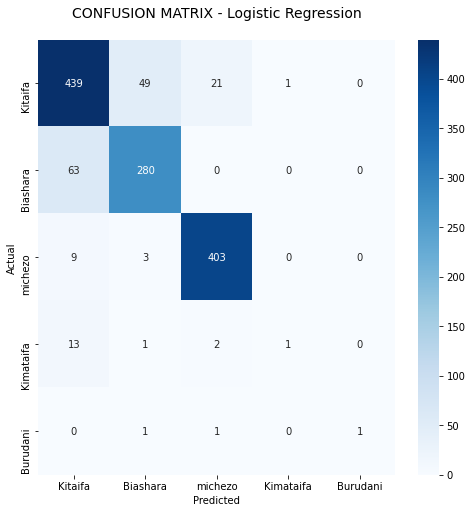

In [ ]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=new_df.category.values, 
            yticklabels=new_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=14)

In [ ]:
for predicted in new_df.label_id:
    for actual in new_df.label_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("actual class '{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 
                                                                'content']])
            print('')

actual class 'Biashara' predicted as 'Kitaifa' : 63 examples.


,category,content
2097,Biashara,rais john magufuli leo anakutana wafanyabiasha...
1264,Biashara,waziri mkuu kassim majaliwa ameitaka wizara ki...
3722,Biashara,kipindi mwaka mmoja kufikia desemba mwaka jana...
3251,Biashara,hayo yalibainishwa mwishoni wiki waziri fedha ...
4557,Biashara,mpango uliopewa jina kili challenge unadhamini...
...,...,...
4107,Biashara,waziri huyo aliyeongozana waziri maji umwagili...
921,Biashara,nchemba aliyasema hayo mwishoni wiki bungeni m...
3278,Biashara,ameyasema hayo dar es salaam kongamano siku ku...
3077,Biashara,mujibu momgela ongezeko wafanyabiashara jiji a...



actual class 'Kitaifa' predicted as 'Biashara' : 49 examples.


,category,content
1141,Kitaifa,waziri madini angellah kairuki amesema wizara ...
678,Kitaifa,meneja mamlaka usimamizi bima tira kanda stell...
2905,Kitaifa,waziri habari utamaduni sanaa michezo dk harri...
4479,Kitaifa,msimu kuelekea krismasi mwaka mpya wafanyabias...
4538,Kitaifa,kuhakikisha magazeti habarileo spotileo daily ...
440,Kitaifa,rais zanzibar dk ali mohamed shein amesema kut...
4303,Kitaifa,rais john magufuli anatarajiwa mgeni rasmi kil...
4040,Kitaifa,waziri mkuu kassim majaliwa ameutaka mkoa tabo...
1379,Kitaifa,wizara maliasili utalii imeunda kamati yenye j...
473,Kitaifa,wananchi vijiji kitongosima shinembo wilaya ma...



actual class 'Kitaifa' predicted as 'michezo' : 21 examples.


,category,content
4017,Kitaifa,timu taifa afrika car mbili ilitoka nyuma kuil...
2229,Kitaifa,nigeria imetangaza majina wachezaji ajili fain...
4242,Kitaifa,naibu waziri habari utamaduni sanaa michezo ju...
2720,Kitaifa,kinara ligi kuu tanzania bara tpl yanga amepan...
984,Kitaifa,kikosi mabingwa soka tanzania bara simba jana ...
3689,Kitaifa,mbio ubingwa ligi kuu bara vigogo ligi yanga a...
1848,Kitaifa,kuelekea kilele tamasha tigo fiesta kesho wasa...
1960,Kitaifa,klabu azam fc imewatema nyota wanane kikosi ms...
372,Kitaifa,mwanaume kijiji obama jimbo migori nchini keny...
1299,Kitaifa,msanii muziki nchini richard mavoko amekanusha...


In [ ]:
'''
# save the model
model_filename = open('finalized_model.sav', 'wb')
pickle.dump(model, model_filename)
model_filename.close()
# save fitted vectorizer to use for the prediction time
tf_idf_output = open('fitted_vectorizer.pickle', 'wb')
pickle.dump(fitted_vectorizer, tf_idf_output)
tf_idf_output.close()
# save the dictionaries
output1 = open('category_to_id.pkl', 'wb')
pickle.dump(category_to_id, output1)
output1.close()
output2 = open('id_to_category.pkl', 'wb')
pickle.dump(id_to_category, output2)
output2.close()
'''

In [ ]:
to_predict = "KOCHA wa Senegal, Alliou Cisse amesema timu yake itazoea mechi hadi mechi kwenye michuano ya Afcon akiwa na lengo la kufanya vizuri kuliko michuano ya mwisho iliyofanyika Gabon mwaka 2017, ambapo Senegal iliishia robo fainali.Cisse ni miongoni mwa makocha wachache wanaoonekana kwenye michuano hiyo mfululizo kuanzia ile iliyopita. Simba wa Teranga wamepangwa kundi C pamoja na Algeria, Kenya na Tanzania.Akizungumzia nafasi yake kwenye kundi hilo, Cisse alisema kundi liko sawa. “Ni kundi lililo sawa kwa timu yangu, kwa sasa hakuna timu ndogo au kubwa. Timu zote zilizofuzu zitakuwa Misri kupambana na kujaribu kupata matokeo mazuri.” “Tutakuwa na Algeria sio ngeni kwenye michuano hii, pia kuna Kenya na Tanzania. Hatuzidharau Kenya na Tanzania kutokana na hali zao, tunatakiwa kujiandaa vizuri kushindana.”Mechi yake na Algeria itakuwa ya tatu mfululizo, amejiandaa vipi? “ Ni mara ya tatu tunacheza na Algeria kwenye hatua ya makundi. Tulicheza 2015 (Equatorial Guinea), 2017 (Gabon), na sasa Misri, ni historia ndefu kwa timu hizi Algeria imebadilika tangu kuwasili kwa Djamel Belmadi, ambaye ni rafiki yangu, tumekuwa pamoja majirani Paris itakuwa mechi nzuri.”Senegal na Algeria ndio zinapewa nafasi kubwa kwenye kundi hili, lakini Kenya na Tanzania hazipaswi kudharauliwa. “Naweza kusema kwamba Senegal haiiogopi timu yoyote.” Akizungumzia malengo ya timu yake alisema wataichukulia kila mechi kwa uzito wake, kwa sababu wanajua lolote linaweza kutokea. “Ni kweli ni miongoni mwa tunaopewa nafasi kubwa, lakini kufikia kiwango hicho tunatakiwa kumfunga kila tunayekutana naye, na itaanza na Tanzania Juni 23, tunapaswa kufikiria uwezo wetu na si kuwafikia adui zetu."
clean_to_predict = [clean_text(to_predict)]
#to_pred_features = tfidf.fit_transform(clean_to_predict).toarray()
#to_pred_features




---

